<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [7]:
#Start Here
import numpy as np
import pandas as pd
import seaborn as sns
import re

import spacy
nlp = spacy.load('en_core_web_lg')

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis.gensim

In [4]:
# !unzip Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip

Archive:  Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip
replace Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [8]:
df = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [9]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [12]:
# adding to the stopwords and tokenizing the dataset
STOPWORDS = set(STOPWORDS).union(set(['amazon']))

def tokenize(text):
    return [token for token in simple_preprocess(text, deacc=True, min_len=4, max_len=20) if token not in STOPWORDS]

In [13]:
# testing tokenize function
test_string = "this is the test string that i'm trying to work with"

test_tokens = tokenize(test_string)
tokenize(test_string)

['test', 'string', 'trying', 'work']

In [14]:
#casting strings to lower, tokenizing the text
def wrangle(df):
    new_df = df.copy()
    new_df['brand'] = new_df['brand'].apply(lambda x: x.lower())
    new_df['tokens'] = new_df['reviews.text'].apply(tokenize)
    new_df = new_df[['brand', 'reviews.text', 'tokens']]
    return new_df

df = wrangle(df)
df.head()

,brand,reviews.text,tokens
0,amazonbasics,I order 3 of them and one of the item is bad q...,"[order, item, quality, missing, backup, spring..."
1,amazonbasics,Bulk is always the less expensive way to go fo...,"[bulk, expensive, products, like]"
2,amazonbasics,Well they are not Duracell but for the price i...,"[duracell, price, happy]"
3,amazonbasics,Seem to work as well as name brand batteries a...,"[work, brand, batteries, better, price]"
4,amazonbasics,These batteries are very long lasting the pric...,"[batteries, long, lasting, price, great]"


In [15]:
#getting one specific review
df.loc[10, 'reviews.text']

"I find amazon basics batteries to be equal if not superior to name brand ones. Can't believe I didn't start buying them sooner! The packages are large and the price is great too."

In [17]:
# Streaming the amazon reviews
def get_review(df, token_col):
    for index, row in df.iterrows():
        review_token = row[token_col]
        yield review_token

In [18]:
#creating a corpus dictionary across all of the amazon reviews
id2word = corpora.Dictionary(get_review(df, 'tokens'))
id2word.token2id['batteries']

16

In [19]:
id2word.doc2bow(test_tokens)

[(8, 1), (388, 1), (641, 1), (1174, 1)]

In [20]:
#for each amazon review, we are tokenizing the text, and putting those tokens into a bag of words ID mapping
corpus = [id2word.doc2bow(tokens) for tokens in get_review(df, 'tokens')]

In [21]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [22]:
lda.print_topics()

[(0,
  '0.051*"purchase" + 0.028*"happy" + 0.016*"worked" + 0.013*"exactly" + 0.012*"needed" + 0.012*"pleased" + 0.012*"described" + 0.011*"bought" + 0.010*"arrived" + 0.009*"working"'),
 (1,
  '0.027*"alexa" + 0.026*"music" + 0.022*"sound" + 0.022*"great" + 0.020*"echo" + 0.019*"speaker" + 0.016*"portable" + 0.011*"like" + 0.011*"bluetooth" + 0.009*"device"'),
 (2,
  '0.120*"batteries" + 0.067*"work" + 0.063*"good" + 0.058*"price" + 0.056*"long" + 0.036*"great" + 0.032*"brand" + 0.024*"brands" + 0.023*"quality" + 0.014*"time"'),
 (3,
  '0.050*"batteries" + 0.026*"battery" + 0.021*"charge" + 0.016*"good" + 0.012*"duracell" + 0.011*"life" + 0.009*"longer" + 0.009*"lasted" + 0.008*"hold" + 0.008*"power"'),
 (4,
  '0.038*"expected" + 0.030*"bought" + 0.029*"love" + 0.029*"grandkids" + 0.022*"sure" + 0.021*"eyes" + 0.018*"going" + 0.012*"real" + 0.010*"work" + 0.009*"kindles"'),
 (5,
  '0.098*"batteries" + 0.015*"battery" + 0.013*"long" + 0.013*"time" + 0.011*"toys" + 0.009*"brand" + 0.009

In [23]:
def print_lda_topics(lda):
    words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
    topics = [' '.join(t[0:5]) for t in words]
    for id, t in enumerate(topics): 
        print(f"------ Topic {id} ------")
        print(t, end="\n\n")
print_lda_topics(lda)

------ Topic 0 ------
purchase happy worked exactly needed

------ Topic 1 ------
alexa music sound great echo

------ Topic 2 ------
batteries work good price long

------ Topic 3 ------
batteries battery charge good duracell

------ Topic 4 ------
expected bought love grandkids sure

------ Topic 5 ------
batteries battery long time toys

------ Topic 6 ------
screen easy ipad tablet kindle

------ Topic 7 ------
kindle tablet reading love read

------ Topic 8 ------
kids tablet love great time

------ Topic 9 ------
apps great tablet friendly like

------ Topic 10 ------
tablet best store tablets play

------ Topic 11 ------
great price tablet battery product

------ Topic 12 ------
great recommend tablet product easy

------ Topic 13 ------
loves bought year games books

------ Topic 14 ------
good nice price product tablet



In [24]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [25]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

//anaconda3/envs/NLPEnv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.236725  0.082272       1        1  10.634424
13     0.230388  0.130160       2        1   9.281878
2     -0.269704 -0.111971       3        1   9.138660
7      0.063336  0.089210       4        1   8.810568
8      0.190143  0.022740       5        1   8.353276
6      0.153209  0.059557       6        1   8.016608
12     0.163239 -0.043667       7        1   6.565516
11    -0.033288 -0.274669       8        1   6.434657
3     -0.229515  0.086302       9        1   5.967965
14     0.032323 -0.246221      10        1   5.710111
10     0.059496 -0.039230      11        1   5.259939
9      0.101818 -0.071505      12        1   4.596930
1     -0.045751 -0.001965      13        1   4.500619
0     -0.140070  0.119844      14        1   3.962367
4     -0.038900  0.199143      15        1   2.766469, topic_info=     Category         Freq       Term        Total  loglift  logprob
19    Default  8947.000000      great  8947.000000  30.0000  30.0000
16    Default  6965.000000  batteries  6965.000000  29.0000  29.0000
30    Default  5447.000000       good  5447.000000  28.0000  28.0000
15    Default  4780.000000      price  4780.000000  27.0000  27.0000
179   Default  2440.000000       kids  2440.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
134   Topic15    44.010777    working   390.359528   1.4050  -5.1771
21    Topic15    46.774616       long  2349.183594  -0.3289  -5.1162
11    Topic15    44.100563       like  2466.052734  -0.4363  -5.1751
2235  Topic15    41.096436      model   228.229294   1.8732  -5.2456
2922  Topic15    42.110767     kindle  3017.574951  -0.6843  -5.2213

[1107 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2722     14  0.962301  abilities
95        2  0.287094       able
95        3  0.003480       able
95        4  0.179217       able
95        5  0.149637       able
...     ...       ...        ...
164      12  0.034070      years
164      13  0.001793      years
164      14  0.017932      years
164      15  0.048415      years
1871      9  0.972793       zone

[3482 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 14, 3, 8, 9, 7, 13, 12, 4, 15, 11, 10, 2, 1, 5])

In [26]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
print(f'Coherence score: {cm.get_coherence()}')

Coherence score: -3.5287150605705135


In [27]:
def compute_coherence_values(dictionary, corpus, df, token_col, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    
    tokens = list(get_review(df, token_col))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            
            model_list.append(model)
            
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return model_list, coherence_values

In [28]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        df=df,
                                                        token_col='tokens',
                                                        start=2, 
                                                        limit=14, 
                                                        step=1,
                                                        passes=5)

In [29]:
len(coherence_values), len(model_list)

(60, 60)

In [30]:
coherence_values[0]

{'pass': 0, 'num_topics': 2, 'coherence_score': -2.7720217430192298}

In [31]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-2.772022
1,0,3,-2.828444
2,0,4,-2.804507
3,0,5,-2.703896
4,0,6,-2.828994


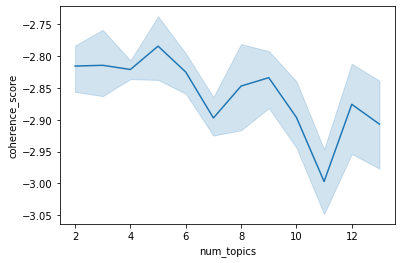

In [32]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [33]:
best_lda = model_list[2]

In [34]:
#Visualize LDA
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_lda, corpus, id2word)#, sort=False)

//anaconda3/envs/NLPEnv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.019277 -0.038702       1        1  28.501583
2      0.057401  0.031118       2        1  25.685966
3     -0.057770  0.034634       3        1  23.254059
0      0.019647 -0.027050       4        1  22.558388, topic_info=     Category         Freq       Term        Total  loglift  logprob
3888  Default  6674.000000     tablet  6674.000000  30.0000  30.0000
19    Default  9511.000000      great  9511.000000  29.0000  29.0000
16    Default  6804.000000  batteries  6804.000000  28.0000  28.0000
8     Default  2246.000000       work  2246.000000  27.0000  27.0000
15    Default  4814.000000      price  4814.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
92     Topic4   330.273193       year  1962.284912  -0.2929  -5.2602
421    Topic4   274.149017       play  1222.210327  -0.0057  -5.4464
2079   Topic4   277.969788     screen  1689.217529  -0.3154  -5.4326
168    Topic4   253.477371       nice  1218.695679  -0.0812  -5.5248
8      Topic4   267.331543       work  2246.681641  -0.6397  -5.4716

[388 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
7707      1  0.824027   abke
95        1  0.290983   able
95        2  0.171472   able
95        3  0.169740   able
95        4  0.367192   able
...     ...       ...    ...
92        4  0.168171   year
164       1  0.240356  years
164       2  0.225450  years
164       3  0.137879  years
164       4  0.395004  years

[871 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling